# NNDL HomeWork 4
This is the fourth homework of NNDL course about RNNs  
by **Ali Ranjbari**

## Imports and installs

In [1]:
!pip install -q torchmetrics

     |████████████████████████████████| 512 kB 15.7 MB/s 


In [20]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import os
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import nltk
from torchmetrics import (
  R2Score,
  MeanAbsoluteError,
  MeanSquaredError,
)
from torchmetrics.functional.classification import (
    multiclass_accuracy,
    multiclass_precision,
    multiclass_f1_score,
    multiclass_recall
)
from torchtext.vocab import GloVe
from torchtext.data import get_tokenizer
from sklearn.model_selection import train_test_split

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device is {device}')

device is cuda


## Q1) Air Pollution Detection

### 1. Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cp drive/MyDrive/Datasets/NNDL_HW04/* .
!unzip PRSA2017_Data_20130301-20170228.zip
%cd PRSA2017_Data_20130301-20170228/PRSA_Data_20130301-20170228/
%ls .

Archive:  PRSA2017_Data_20130301-20170228.zip
   creating: PRSA2017_Data_20130301-20170228/PRSA_Data_20130301-20170228/
  inflating: PRSA2017_Data_20130301-20170228/PRSA_Data_20130301-20170228/PRSA_Data_Aotizhongxin_20130301-20170228.csv  
  inflating: PRSA2017_Data_20130301-20170228/PRSA_Data_20130301-20170228/PRSA_Data_Changping_20130301-20170228.csv  
  inflating: PRSA2017_Data_20130301-20170228/PRSA_Data_20130301-20170228/PRSA_Data_Dingling_20130301-20170228.csv  
  inflating: PRSA2017_Data_20130301-20170228/PRSA_Data_20130301-20170228/PRSA_Data_Dongsi_20130301-20170228.csv  
  inflating: PRSA2017_Data_20130301-20170228/PRSA_Data_20130301-20170228/PRSA_Data_Guanyuan_20130301-20170228.csv  
  inflating: PRSA2017_Data_20130301-20170228/PRSA_Data_20130301-20170228/PRSA_Data_Gucheng_20130301-20170228.csv  
  inflating: PRSA2017_Data_20130301-20170228/PRSA_Data_20130301-20170228/PRSA_Data_Huairou_20130301-20170228.csv  
  inflating: PRSA2017_Data_20130301-20170228/PRSA_Data_20130301-201

In [ ]:
df = pd.read_csv("./PRSA_Data_Aotizhongxin_20130301-20170228.csv")

In [ ]:
names = os.listdir()
# df = pd.DataFrame()
for name in names:
  if "Aotizhongxin" in name:
    continue

  df_temp = pd.read_csv(name)
  station_name = name.split("_")[2][0:4]
  df[f"PM2.5_{station_name}"] = df_temp["PM2.5"]

df = df.drop("station", axis=1)

In [ ]:
df_PM = df.copy()
for c in df_PM.columns:
  if 'PM2.5' not in c:
    df_PM.drop(c, axis=1, inplace=True)
    print(f"droped {c}")

droped No
droped year
droped month
droped day
droped hour
droped PM10
droped SO2
droped NO2
droped CO
droped O3
droped TEMP
droped PRES
droped DEWP
droped RAIN
droped wd
droped WSPM


### 2. Preprocessing

#### 2.1 Missing value
Handling missing values with Linear interpolation method

In [ ]:
df = df.interpolate(method="linear", limit_direction = "forward")

In [ ]:
df_PM = df_PM.interpolate(method="linear", limit_direction = "forward")

#### 2.2 Encoding Categorical Variable


In [ ]:
values = ["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE", "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW", "N"]
degrees = [ i*22.5 for i in range(17)]

In [ ]:
df['wd'].replace(values, degrees, inplace=True)

In [ ]:
# "wd" column still has NaN values so after converting to degree we perform LI
df = df.interpolate(method="linear", limit_direction = "forward")

#### 2.3 Normalization
Normalize using min-max normalization

In [ ]:
for column in df.columns:
  df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())

In [ ]:
for column in df_PM.columns:
  df_PM[column] = (df_PM[column] - df_PM[column].min()) / (df_PM[column].max() - df_PM[column].min())

#### 2.4 Pearson Correlation
Just for PM columns

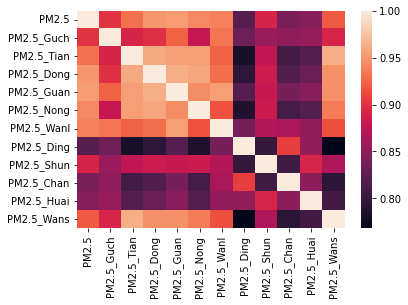

In [ ]:
corr = df_PM.corr(method="pearson")
sns.heatmap(corr)
plt.show()

#### 2.5 Feature selection

In [ ]:
# features is this columns and all column that have PM in it
features = ["CO", "TEMP", "PRES", "DEWP", "RAIN", "wd", "WSPM"]
for c in df.columns:
  if c in features or 'PM' in c:
    continue
  df = df.drop(c, axis=1)

Now save the table as csv with name `PRSA_Data_features.csv`

In [ ]:
df.to_csv("../../PRSA_Data_features.csv")

#### 2.5 Supervised dataset
Convert data to supervised and ready for training  
We built two dataset 1 and 7 days lag  

In [ ]:
X_lag1 = []
y_lag1 = []
df_np = df.to_numpy()
for i in range(0, df.shape[0]-24):
  X_lag1.append(
      np.expand_dims(df_np[i:i+24, :], axis=0))
  y_lag1.append(
      np.expand_dims(df_np[i+24, 0], axis=0))
  
# concatination
X1 = np.concatenate(X_lag1)
y1 = np.concatenate(y_lag1)

# train test split (80-20)
train_size = ceil(X1.shape[0] * 0.8)
X1_train = X1[0:train_size, :, :]
X1_test = X1[train_size:, :, :]
y1_train = y1[0:train_size]
y1_test = y1[train_size:]

In [ ]:
X_lag7 = []
y_lag7 = []
df_np = df.to_numpy()
step = (24 * 7) 
for i in range(0, df.shape[0]-step):
  X_lag7.append(
      np.expand_dims(df_np[i:i+step, :], axis=0))
  y_lag7.append(
      np.expand_dims(df_np[i+step, 0], axis=0))

# concatination
X7 = np.concatenate(X_lag7)
y7 = np.concatenate(y_lag7)

# train test split (80-20)
train_size = ceil(X7.shape[0] * 0.8)
X7_train = X7[0:train_size,:,:]
X7_test = X7[train_size:, :, :]
y7_train = y7[0:train_size]
y7_test = y7[train_size:]

In [ ]:
class PollutionDataset(Dataset):
  def __init__(self, X: torch.Tensor, y: torch.Tensor):
    super().__init__()
    self.input = torch.tensor(X, dtype=torch.float)
    self.target = torch.tensor(y, dtype=torch.float)

  def __getitem__(self, idx):
    return self.input[idx], self.target[idx]
  
  def __len__(self):
    return self.input.shape[0]

In [ ]:
train1_dataset = PollutionDataset(X1_train, y1_train) 
test1_dataset = PollutionDataset(X1_test, y1_test) 
train7_dataset = PollutionDataset(X7_train, y7_train) 
test7_dataset = PollutionDataset(X7_test, y7_test) 

### 3. Build the model 

In [ ]:
class CNN_LSTM(nn.Module):

  def __init__(self, seq_size: int):
    super().__init__()

    # conv self
    self.conv1 = nn.Conv1d(seq_size, 64, 3, padding="same",
                           padding_mode='zeros')              # 20 -> 20
    self.norm1 = nn.BatchNorm1d(64)
    self.conv2 = nn.Conv1d(64, 64, 3, paddin3g="same",
                           padding_mode='zeros')              # 20 -> 20
    self.norm2 = nn.BatchNorm1d(64)
    self.conv3 = nn.Conv1d(64, 32, 3, padding="same",
                           padding_mode='zeros')              # 20 -> 20 
    self.max_pool = nn.MaxPool1d(3)                           # 20 -> 6


    # lstm layer
    self.lstm1 = nn.LSTM(input_size=6, hidden_size=100, batch_first=True)
    self.lstm2 = nn.LSTM(input_size=100, hidden_size=50, batch_first=True)
    self.drop02 = nn.Dropout1d(0.2)
    self.drop03 = nn.Dropout1d(0.3)
    
    # output layer
    self.fc = nn.Linear(50*32, 1)


  def forward(self, x):

    # conv layer
    x = F.relu(self.conv1(x))
    x = self.norm1(x)
    x = F.relu(self.conv2(x))
    x = self.norm2(x)
    x = F.relu(self.conv3(x))
    x = self.max_pool(x)

    # lstm layer
    x = self.drop02(self.lstm1(x)[0])
    x = self.drop03(self.lstm2(x)[0])


    x = x.reshape((-1, 50*32))
    # output layer
    x = F.relu(self.fc(x))
    x = x.squeeze()

    return x

### 4. Train

In [ ]:
model1 = CNN_LSTM(seq_size=24)
model1.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model1.parameters(),
                                lr=0.001, weight_decay=0.0001)

mse_metric = MeanSquaredError().to(device)
mae_metric = MeanAbsoluteError().to(device)
r2_metric = R2Score().to(device)
train1_dataloader = DataLoader(train1_dataset,
                              batch_size = 32, shuffle=True)

In [ ]:
# learning loop
r2s = []
maes = []
rmses = []
EPOCHS = 50

n_total = len(train1_dataloader)
for epoch in range(1, EPOCHS+1):
  targets = []
  print(f"*************** Epoch {epoch} ***************")
  print(" [Epoch] |  Loss  |  R2  |  MAE  |  RMSE  ")
  for i, (inputs, target) in enumerate(train1_dataloader):
    
    inputs = inputs.to(device)
    target = target.to(device)

    predicted = model1(inputs)
    
    optimizer.zero_grad()
    loss = criterion(predicted, target)
    loss.backward()
    optimizer.step()

    
    if (i+1) % 300 == 0:
      with torch.no_grad():
        r2 = r2_metric(predicted, target)
        mae = mae_metric(predicted, target)
        mse = mse_metric(predicted, target)
        print(f"[{i+1}/{n_total}]  {loss.item():.3f}   {r2.item():.3f}   {mae.item():.3f}   {torch.sqrt(mse).item():.3f}")

  r2s.append(r2.item())
  maes.append(mae.item())
  rmses.append(torch.sqrt(mse).item())
  


*************** Epoch 1 ***************
 [Epoch] |  Loss  |  R2  |  MAE  |  RMSE  
[300/876]  0.001   0.898   0.026   0.033
[600/876]  0.001   0.819   0.027   0.033
*************** Epoch 2 ***************
 [Epoch] |  Loss  |  R2  |  MAE  |  RMSE  
[300/876]  0.001   0.889   0.023   0.037
[600/876]  0.001   0.872   0.018   0.024
*************** Epoch 3 ***************
 [Epoch] |  Loss  |  R2  |  MAE  |  RMSE  
[300/876]  0.001   0.920   0.020   0.026
[600/876]  0.000   0.916   0.013   0.017
*************** Epoch 4 ***************
 [Epoch] |  Loss  |  R2  |  MAE  |  RMSE  
[300/876]  0.001   0.922   0.023   0.033
[600/876]  0.000   0.971   0.013   0.019
*************** Epoch 5 ***************
 [Epoch] |  Loss  |  R2  |  MAE  |  RMSE  
[300/876]  0.000   0.966   0.016   0.020
[600/876]  0.001   0.783   0.020   0.034
*************** Epoch 6 ***************
 [Epoch] |  Loss  |  R2  |  MAE  |  RMSE  
[300/876]  0.000   0.953   0.013   0.016
[600/876]  0.000   0.939   0.014   0.019
**********

In [ ]:
model7 = CNN_LSTM(seq_size=24*7)
model7.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model7.parameters(),
                                lr=0.001, weight_decay=0.0001)

mse_metric = MeanSquaredError().to(device)
mae_metric = MeanAbsoluteError().to(device)
r2_metric = R2Score().to(device)
train7_dataloader = DataLoader(train7_dataset,
                              batch_size = 32, shuffle=True)

In [ ]:
# learning loop
r2s = []
maes = []
rmses = []
EPOCHS = 50

n_total = len(train7_dataloader)
for epoch in range(1, EPOCHS+1):
  targets = []
  print(f"*************** Epoch {epoch} ***************")
  print(" [Epoch] |  Loss  |  R2  |  MAE  |  MSE  ")
  for i, (inputs, target) in enumerate(train7_dataloader):
    
    inputs = inputs.to(device)
    target = target.to(device)

    predicted = model7(inputs)
    
    optimizer.zero_grad()
    loss = criterion(predicted, target)
    loss.backward()
    optimizer.step()

    
    if (i+1) % 300 == 0:
      with torch.no_grad():
        r2 = r2_metric(predicted, target)
        mae = mae_metric(predicted, target)
        mse = mse_metric(predicted, target)
        print(f"[{i+1}/{n_total}]  {loss.item():.3f}   {r2.item():.3f}   {mae.item():.3f}   {torch.sqrt(mse).item():.3f}")
  
  r2s.append(r2.item())
  maes.append(mae.item())
  rmses.append(torch.sqrt(mse).item())


*************** Epoch 1 ***************
 [Epoch] |  Loss  |  R2  |  MAE  |  MSE  
[300/873]  0.001   0.891   0.018   0.028
[600/873]  0.001   0.822   0.030   0.038
*************** Epoch 2 ***************
 [Epoch] |  Loss  |  R2  |  MAE  |  MSE  
[300/873]  0.000   0.925   0.015   0.020
[600/873]  0.001   0.954   0.017   0.025
*************** Epoch 3 ***************
 [Epoch] |  Loss  |  R2  |  MAE  |  MSE  
[300/873]  0.001   0.752   0.020   0.026
[600/873]  0.000   0.946   0.017   0.021
*************** Epoch 4 ***************
 [Epoch] |  Loss  |  R2  |  MAE  |  MSE  
[300/873]  0.001   0.837   0.019   0.026
[600/873]  0.000   0.935   0.018   0.022
*************** Epoch 5 ***************
 [Epoch] |  Loss  |  R2  |  MAE  |  MSE  
[300/873]  0.002   0.772   0.025   0.039
[600/873]  0.001   0.961   0.020   0.023
*************** Epoch 6 ***************
 [Epoch] |  Loss  |  R2  |  MAE  |  MSE  
[300/873]  0.000   0.961   0.016   0.020
[600/873]  0.001   0.914   0.018   0.024
*************** 

### 5. Test

First test on `model1` on 24 hours dataset

In [ ]:
with torch.no_grad():
  preds = model1(test1_dataset.input.to(device))
  target = test1_dataset.target.to(device)
  r2 = r2_metric(preds, target)
  mae = mae_metric(preds, target)
  mse = mse_metric(preds, target)
  print(f"R2: {r2.item():.3f}, MAE: {mae.item():.3f}, RMSE: {torch.sqrt(mse).item():.3f}")


R2: 0.818, MAE: 0.028, RMSE: 0.040


Test `model7` on 7 days test data

In [ ]:
with torch.no_grad():
  preds = model7(test7_dataset.input.to(device))
  target = test7_dataset.target.to(device)
  r2 = r2_metric(preds, target)
  mae = mae_metric(preds, target)
  mse = mse_metric(preds, target)
  print(f"R2: {r2.item():.3f}, MAE: {mae.item():.3f}, RMSE: {torch.sqrt(mse).item():.3f}")


R2: 0.930, MAE: 0.016, RMSE: 0.025


## Q2) Fake NEWS Detection

### 1. Loading & Preprocessing The data

In [4]:
# if file is on colab
# from google.colab import drive
# drive.mount('/content/drive')
# %cp drive/MyDrive/Datasets/NNDL_HW04/* .

In [5]:
df = pd.read_csv("./FA-KES-Dataset.csv", encoding="unicode-escape")
df

,unit_id,article_title,article_content,source,date,location,labels
0,1914947530,Syria attack symptoms consistent with nerve ag...,Wed 05 Apr 2017 Syria attack symptoms consiste...,nna,4/5/2017,idlib,0
1,1914947532,Homs governor says U.S. attack caused deaths b...,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,nna,4/7/2017,homs,0
2,1914947533,Death toll from Aleppo bomb attack at least 112,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,nna,4/16/2017,aleppo,0
3,1914947534,Aleppo bomb blast kills six Syrian state TV,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,nna,4/19/2017,aleppo,0
4,1914947535,29 Syria Rebels Dead in Fighting for Key Alepp...,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...,nna,7/10/2016,aleppo,0
...,...,...,...,...,...,...,...
799,1965511221,Turkish Bombardment Kills 20 Civilians in Syria,28-08-2016 Turkish Bombardment Kills 20 Civili...,manar,8/28/2016,aleppo,1
800,1965511222,Martyrs as Terrorists Shell Aleppos Salah Eddin,17-08-2016 Martyrs as Terrorists Shell Aleppos...,manar,8/1/2016,aleppo,1
801,1965511224,Chemical Attack Kills Five Syrians in Aleppo SANA,03-08-2016 Chemical Attack Kills Five Syrians ...,manar,8/3/2016,aleppo,0
802,1965511226,5 Killed as Russian Military Chopper Shot down...,01-08-2016 5 Killed as Russian Military Choppe...,manar,8/1/2016,idlib,1


In [6]:
articles_list = df["article_content"].to_list()
labels_list = df["labels"].to_list()

In [7]:
tokenizer = get_tokenizer("basic_english")
glove_vectors = GloVe(name="6B", dim=100)

.vector_cache/glove.6B.zip: 862MB [02:41, 5.35MB/s]                           
100%|█████████▉| 399999/400000 [00:15<00:00, 25944.54it/s]


Now tokenize and embed the sentences  
In here if sentence has more that 300 tokens we truncated it and if the sentence has less than 300 tokens we padded it with " " 

In [8]:
articles_emb = []
for a in articles_list:
  
  tokens = tokenizer(a)
  tokens_len = len(tokens)
  if tokens_len < 300:
    tokens.extend([""]*(300-tokens_len))
  elif tokens_len > 300:
    tokens = tokens[:300]

  embeddings = glove_vectors.get_vecs_by_tokens(tokens)
  articles_emb.append(embeddings.unsqueeze(0))


X = torch.cat(articles_emb)
y = torch.tensor(labels_list)

Split the data to train and test (80-20)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
class NewsDataset(Dataset):
  def __init__(self, X: torch.Tensor, y: torch.Tensor):
    super().__init__()
    self.input = X
    self.target = y

  def __getitem__(self, idx):
    return self.input[idx], self.target[idx]
  
  def __len__(self):
    return self.input.shape[0]

In [11]:
train_dataset = NewsDataset(X_train, y_train)
test_dataset = NewsDataset(X_test, y_test)

### 2. Building the models

First build the `hybrid(CNN-RNN)`

In [12]:
class Hybrid(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv1d(300, 128, 5)     # 300 * 100 -> 128 * 96
    self.maxpool = nn.MaxPool1d(2)          # 128 * 94 -> 128 * 48
    self.lstm = nn.LSTM(input_size=48, hidden_size=32, batch_first=True)
    self.fc = nn.Linear(32*128, 2)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.maxpool(x)
    x = self.lstm(x)[0]
    x = x.reshape((-1, 32*128))
    x = self.fc(x)

    return x

Now build a simple `RNN` model

In [ ]:
class RNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.lstm1 = nn.LSTM(input_size=100, hidden_size=64, batch_first=True)
    self.lstm2 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)
    self.lstm3 = nn.LSTM(input_size=32, hidden_size=8, batch_first=True)
    self.fc = nn.Linear(300*8, 2)

  def forward(self, x):
    x = self.lstm1(x)[0]
    x = self.lstm2(x)[0]
    x = self.lstm3(x)[0]
    x = x.reshape((-1, 300*8))
    x = self.fc(x)
    return x



### 3. Training

#### 1.) Hybrid CNN-RNN model

In [28]:
model_hyb = Hybrid()
model_hyb.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_hyb.parameters(),
                                lr=0.01)

train_dataloader = DataLoader(train_dataset,
                              batch_size = 64, shuffle=True)

In [29]:
# learning loop
f1_list = []
prec_list = []
acc_list = []
rec_list = []

EPOCHS = 50

n_total = len(train_dataloader)
for epoch in range(1, EPOCHS+1):
  targets = []
  print(f"*************** Epoch {epoch} ***************")
  print(" [Epoch] |   Loss   |   Acc   |   Pre   |   F1    |  Recall ")
  for i, (inputs, target) in enumerate(train_dataloader):
    
    inputs = inputs.to(device)
    target = target.to(device)

    predicted = model_hyb(inputs)
    
    optimizer.zero_grad()
    loss = criterion(predicted, target)
    loss.backward()
    optimizer.step()

    
    if (i+1) % 3 == 0:
      with torch.no_grad():
        ac = multiclass_accuracy(predicted, target, num_classes=2).item()
        pr = multiclass_precision(predicted, target, num_classes=2).item()
        f1 = multiclass_f1_score(predicted, target, num_classes=2).item()
        re = multiclass_recall(predicted, target, num_classes=2).item()
        f1_list.append(f1)
        prec_list.append(pr)
        acc_list.append(ac)
        rec_list.append(re)
        print(f" [{i+1}/{n_total}]  |   {loss.item():.3f}  |  {ac:.3f}  |  {pr:.3f}  |  {f1:.3f}  |  {re:.3f}")


*************** Epoch 1 ***************
 [Epoch] |   Loss   |   Acc   |   Pre   |   F1    |  Recall 
 [3/11]  |   2.345  |  0.500  |  0.297  |  0.373  |  0.500
 [6/11]  |   0.965  |  0.500  |  0.250  |  0.333  |  0.500
 [9/11]  |   0.882  |  0.500  |  0.281  |  0.360  |  0.500
*************** Epoch 2 ***************
 [Epoch] |   Loss   |   Acc   |   Pre   |   F1    |  Recall 
 [3/11]  |   0.729  |  0.500  |  0.273  |  0.354  |  0.500
 [6/11]  |   0.803  |  0.500  |  0.234  |  0.319  |  0.500
 [9/11]  |   0.686  |  0.488  |  0.310  |  0.379  |  0.488
*************** Epoch 3 ***************
 [Epoch] |   Loss   |   Acc   |   Pre   |   F1    |  Recall 
 [3/11]  |   0.778  |  0.500  |  0.250  |  0.333  |  0.500
 [6/11]  |   0.686  |  0.500  |  0.289  |  0.366  |  0.500
 [9/11]  |   0.696  |  0.504  |  0.509  |  0.428  |  0.504
*************** Epoch 4 ***************
 [Epoch] |   Loss   |   Acc   |   Pre   |   F1    |  Recall 
 [3/11]  |   0.703  |  0.571  |  0.631  |  0.479  |  0.571
 [6/11

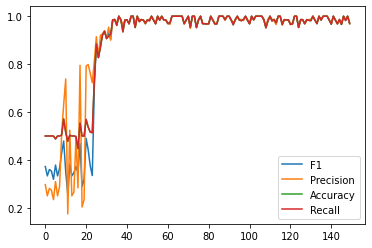

In [30]:
plt.plot(f1_list)
plt.plot(prec_list)
plt.plot(acc_list)
plt.plot(rec_list)
plt.legend(("F1", "Precision", "Accuracy", "Recall"))
plt.show()

#### 2. RNN model

In [32]:
model_rnn = Hybrid()
model_rnn.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rnn.parameters(),
                                lr=0.01)

train_dataloader = DataLoader(train_dataset,
                              batch_size = 64, shuffle=True)

In [33]:
# learning loop
f1_list = []
prec_list = []
acc_list = []
rec_list = []

EPOCHS = 50

n_total = len(train_dataloader)
for epoch in range(1, EPOCHS+1):
  targets = []
  print(f"*************** Epoch {epoch} ***************")
  print(" [Epoch] |   Loss   |   Acc   |   Pre   |   F1    |  Recall ")
  for i, (inputs, target) in enumerate(train_dataloader):
    
    inputs = inputs.to(device)
    target = target.to(device)

    predicted = model_rnn(inputs)
    
    optimizer.zero_grad()
    loss = criterion(predicted, target)
    loss.backward()
    optimizer.step()

    
    if (i+1) % 3 == 0:
      with torch.no_grad():
        ac = multiclass_accuracy(predicted, target, num_classes=2).item()
        pr = multiclass_precision(predicted, target, num_classes=2).item()
        f1 = multiclass_f1_score(predicted, target, num_classes=2).item()
        re = multiclass_recall(predicted, target, num_classes=2).item()
        f1_list.append(f1)
        prec_list.append(pr)
        acc_list.append(ac)
        rec_list.append(re)
        print(f" [{i+1}/{n_total}]  |   {loss.item():.3f}  |  {ac:.3f}  |  {pr:.3f}  |  {f1:.3f}  |  {re:.3f}")


*************** Epoch 1 ***************
 [Epoch] |   Loss   |   Acc   |   Pre   |   F1    |  Recall 
 [3/11]  |   4.745  |  0.500  |  0.188  |  0.273  |  0.500
 [6/11]  |   0.727  |  0.456  |  0.419  |  0.401  |  0.456
 [9/11]  |   0.705  |  0.500  |  0.500  |  0.433  |  0.500
*************** Epoch 2 ***************
 [Epoch] |   Loss   |   Acc   |   Pre   |   F1    |  Recall 
 [3/11]  |   0.688  |  0.509  |  0.518  |  0.478  |  0.509
 [6/11]  |   0.698  |  0.536  |  0.536  |  0.531  |  0.536
 [9/11]  |   0.694  |  0.484  |  0.238  |  0.319  |  0.484
*************** Epoch 3 ***************
 [Epoch] |   Loss   |   Acc   |   Pre   |   F1    |  Recall 
 [3/11]  |   0.687  |  0.500  |  0.242  |  0.326  |  0.500
 [6/11]  |   0.694  |  0.500  |  0.219  |  0.304  |  0.500
 [9/11]  |   0.696  |  0.500  |  0.203  |  0.289  |  0.500
*************** Epoch 4 ***************
 [Epoch] |   Loss   |   Acc   |   Pre   |   F1    |  Recall 
 [3/11]  |   0.694  |  0.500  |  0.234  |  0.319  |  0.500
 [6/11

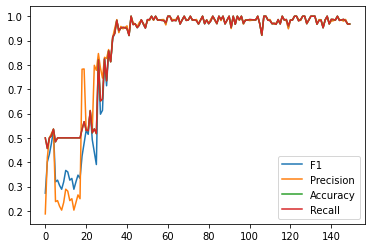

In [35]:
plt.plot(f1_list)
plt.plot(prec_list)
plt.plot(acc_list)
plt.plot(rec_list)
plt.legend(("F1", "Precision", "Accuracy", "Recall"))
plt.show()

### 4. Testing
As we can see in the paper no one of this models has accuracies higher than 60 and the result we got here is very close to the paper

Test Hybrid CNN-RNN model

In [31]:
with torch.no_grad():
  preds = model_hyb(test_dataset.input.to(device))
  target = test_dataset.target.to(device)
  ac = multiclass_accuracy(preds, target, num_classes=2).item()
  pr = multiclass_precision(preds, target, num_classes=2).item()
  f1 = multiclass_f1_score(preds, target, num_classes=2).item()
  re = multiclass_recall(preds, target, num_classes=2).item()
  print(f"Accuracy: {ac:.3f}, F1: {f1:.3f}, Precision: {pr:.3f}, Recall: {re:.3f}")

Accuracy: 0.548, F1: 0.548, Precision: 0.549, Recall: 0.548


Test RNN model

In [34]:
with torch.no_grad():
  preds = model_rnn(test_dataset.input.to(device))
  target = test_dataset.target.to(device)
  ac = multiclass_accuracy(preds, target, num_classes=2).item()
  pr = multiclass_precision(preds, target, num_classes=2).item()
  f1 = multiclass_f1_score(preds, target, num_classes=2).item()
  re = multiclass_recall(preds, target, num_classes=2).item()
  print(f"Accuracy: {ac:.3f}, F1: {f1:.3f}, Precision: {pr:.3f}, Recall: {re:.3f}")

Accuracy: 0.495, F1: 0.494, Precision: 0.495, Recall: 0.495
